In [2]:
# Import necessary libraries
import json
from tqdm.notebook import tqdm
from vespa.deployment import VespaDocker
from vespa.io import VespaResponse
import pytrec_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

In [3]:
docs_json_path = 'data/plain_docs.json'  
with open(docs_json_path, 'r', encoding='utf-8') as f:
    raw_content = f.read()
    documents = json.loads(raw_content)
    financial_times_docs = []
    for doc in tqdm(documents, total=len(documents), desc="Loading JSON", unit=" documents"):
        financial_times_docs.append(doc)

print(f"Total documents loaded: {len(financial_times_docs)}")
print("Sample document:", financial_times_docs[0])

Loading JSON:   0%|          | 0/209831 [00:00<?, ? documents/s]

Total documents loaded: 209831
Sample document: {'docid': 'FT931-15931', 'headline': 'ft 09 jan 93 / briefcase, q&a: agreement desirable', 'text': 'earn income pounds 10,000 unearned income pounds 40,000. assets result inheritance pounds 500,000 house worth pounds 100,000. husband assets earns pounds 25,000. love him, relationship volatile date. marry divorce five years children changes financial positions, risk courts award capital? risk envisage divorce, court power direct financial settlement deems circumstances. contractual agreement settling parties rights (in absence children) desirable. legal responsibility accepted financial times answers given columns. inquiries answered post soon possible.', 'embedding': [-0.027918530628085136, 0.08089904487133026, -0.03913348913192749, 0.06492197513580322, -0.09033701568841934, 0.017969951033592224, 0.037478137761354446, 0.03142697736620903, 0.014147976413369179, 0.013471078127622604, -0.003346281126141548, -0.08918455243110657, 0.0503279119

In [4]:
from vespa.package import ApplicationPackage
app_package = ApplicationPackage(name="ftvespa")

In [5]:
from vespa.package import Document, Field, HNSW
products_document = Document(
    fields=[
        Field(name = "docid",    type = "string", indexing = ["attribute", "summary"]),
        Field(name = "headline",    type = "string", indexing = ["index", "summary"], index = "enable-bm25"),
        Field(name = "text", type = "string", indexing = ["index", "summary"], index = "enable-bm25"),
        Field(name="embedding", type="tensor<float>(x[384])", indexing=["attribute", "index"],
            ann=HNSW(
                distance_metric="euclidean",
                max_links_per_node=16,
                neighbors_to_explore_at_insert=500),
        )
    ]
)

In [6]:
from vespa.package import Schema, FieldSet, RankProfile

products_schema = Schema(
    name="ftvespa",
    document=products_document,
    fieldsets=[FieldSet(name="default", fields=["headline", "text"])],
    rank_profiles=[
        RankProfile(name="bm25", inherits="default", first_phase="bm25(headline) + bm25(text)"),
        RankProfile(name="nativeRank", inherits="default", first_phase="nativeRank(headline,text)"),
        RankProfile(name="embedding_similarity", inherits="default", first_phase="closeness(embedding)"),
        RankProfile(name="bm25_embedding_similarity", inherits="default", first_phase="bm25(headline) + bm25(text) + closeness(embedding)")
    ]
)

In [7]:
from vespa.package import ApplicationPackage, QueryProfile, QueryProfileType, QueryTypeField

app_package = ApplicationPackage(
    name="myapp",
    schema=[products_schema], 
    query_profile=QueryProfile(),
    query_profile_type=QueryProfileType(
        fields=[
                QueryTypeField(
                name="ranking.features.query(embedding_text)",
                type="tensor<float>(x[384])",
            )
        ]
    )
)

In [8]:
print(app_package.get_schema('ftvespa').schema_to_text)

schema ftvespa {
    document ftvespa {
        field docid type string {
            indexing: attribute | summary
        }
        field headline type string {
            indexing: index | summary
            index: enable-bm25
        }
        field text type string {
            indexing: index | summary
            index: enable-bm25
        }
        field embedding type tensor<float>(x[384]) {
            indexing: attribute | index
            attribute {
                distance-metric: euclidean
            }
            index {
                hnsw {
                    max-links-per-node: 16
                    neighbors-to-explore-at-insert: 500
                }
            }
        }
    }
    fieldset default {
        fields: headline, text
    }
    rank-profile bm25 inherits default {
        first-phase {
            expression {
                bm25(headline) + bm25(text)
            }
        }
    }
    rank-profile nativeRank inherits default {
        first

In [9]:
# Deploy the Vespa application using Docker
vespa_docker = VespaDocker(container_memory="12G")
app = vespa_docker.deploy(application_package=app_package)

print("Vespa deployed successfully.")

Waiting for configuration server, 0/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for application to come up, 0/300 seconds.
Waiting for application to come up, 5/300 seconds.
Waiting for application to come up, 10/300 seconds.
Application is up!
Finished deployment.
Vespa deployed successfully.


In [10]:
batch_feed = [
    {
        "id": doc['docid'], 
        "fields": doc
    }
    for idx, doc in enumerate(financial_times_docs)
]

In [11]:
success_count = 0
pbar = tqdm(total=len(financial_times_docs), desc="Feeding Docs", unit="doc")

def callback(response: VespaResponse, id: str):
    global success_count
    pbar.update(1)
    if response.is_successful():
        success_count += 1
    else:
        print(f"Failed doc {id}, status={response.status_code}: {response.get_json()}")

app.feed_iterable(batch_feed, schema="ftvespa", callback=callback)

pbar.close()
print(f"[feed_docs] Feed complete. {success_count}/{len(financial_times_docs)} successes.")

Feeding Docs:   0%|          | 0/209831 [00:00<?, ?doc/s]

[feed_docs] Feed complete. 209831/209831 successes.


In [12]:
query = {
    'yql': 'select * from sources ftvespa where userQuery();',
    'query': 'search engine',
    'ranking': 'nativeRank',
    'type': 'any',
    'hits': 5
}

In [13]:
results = app.query(body=query)

print('Number of documents retrieved: '+ str(results.number_documents_retrieved))
print('Number of documents returned: '+ str(len(results.hits)))

Number of documents retrieved: 6457
Number of documents returned: 5


In [14]:
QUERIES_FILE = "data/queries.json"
QRELS_FILE = "data/qrels.json"

def load_queries(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found.")
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_qrels(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found.")
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    qrels_dict = {}
    for qid, doc_rel_list in data.items():
        rel_map = {}
        for doc_id, relevance in doc_rel_list:
            rel_map[doc_id] = relevance
        qrels_dict[qid] = rel_map
    return qrels_dict


queries = load_queries(QUERIES_FILE)
qrels = load_qrels(QRELS_FILE)

In [15]:
def preprocess_query(query_text):
    """Basic query preprocessing."""
    # Convert to lowercase
    query = query_text.lower()
    # Remove special characters that might affect Vespa query parsing
    query = query.replace('"', ' ')
    query = query.replace("'", ' ')
    return query

In [16]:
from vespa.io import VespaQueryResponse

TOP_K = 30

def run_vespa_search(app, queries):
    trec_run = {}
    rows_for_csv = []
    
    total_hits_found = 0
    queries_with_hits = 0

    with app.syncio(connections=8) as session:
        for q in tqdm(queries, desc="BM25 Queries", unit="query"):
            qid = q["qid"]
            #query_text = preprocess_query(q["query"])
            query_text = q["query"]
            try:
                response: VespaQueryResponse = session.query(
                    body={
                        'yql': 'select * from sources ftvespa where userQuery();',
                        'query': query_text,  # Add the actual query text here
                        'ranking': 'bm25',
                        "hits": TOP_K,
                        "timeout": "15s",
                        "grammar": "weakAnd"  # Allow partial matches
                    }
                )

                if response.is_successful():
                    hits = response.hits
                    if hits:
                        queries_with_hits += 1
                        total_hits_found += len(hits)
                    
                    doc_scores = {}
                    rank = 1
                    for hit in hits:
                        doc_id = hit["id"].split("::")[-1]
                        score = float(hit["relevance"])

                        doc_scores[doc_id] = score
                        rows_for_csv.append([qid, doc_id, rank, score])
                        rank += 1

                    trec_run[qid] = doc_scores
                else:
                    print(f"\nQuery failed for qid {qid}:")
                    print(f"Status: {response.status_code}")
                    print(f"Response: {response.json}")

            except Exception as e:
                print(f"\nError processing query {qid}: {str(e)}")
                continue

    print(f"\nTotal queries with hits: {queries_with_hits}")
    print(f"Average hits per query: {total_hits_found/len(queries):.2f}")
    
    return trec_run, rows_for_csv

In [17]:
trec_run, rows_for_csv = run_vespa_search(app, queries)

BM25 Queries:   0%|          | 0/150 [00:00<?, ?query/s]


Total queries with hits: 150
Average hits per query: 29.32


In [18]:
import csv
from typing import Dict, List, Tuple

def evaluate_search_results(
    trec_run: Dict,
    qrels: Dict,
    rows_for_csv: List[List],
    output_csv: str = "bm25_topk.csv",
    per_query_json: str = "bm25_per_query.json",
    aggregate_json: str = "bm25_metrics.json"
) -> Tuple[Dict, Dict]:

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrels, {"map", "ndcg", "ndcg_cut_5", "ndcg_cut_10"}
    )
    eval_results = evaluator.evaluate(trec_run)

    metric_sums = {"map": 0.0, "ndcg": 0.0, "ndcg_cut_5": 0.0, "ndcg_cut_10": 0.0}
    per_query_dict = {}
    
    for qid, metrics in eval_results.items():
        per_query_dict[qid] = {m: metrics[m] for m in metric_sums.keys()}
        for m in metric_sums:
            metric_sums[m] += metrics[m]

    num_queries = len(eval_results)
    agg_metrics = {}
    
    if num_queries > 0:
        print(f"\n--- EVALUATION RESULTS over {num_queries} queries ---")
        for m in metric_sums:
            agg_metrics[m] = metric_sums[m] / num_queries
            print(f"{m}: {agg_metrics[m]:.4f}")
    else:
        print("No queries or no evaluated queries found.")
        for m in metric_sums:
            agg_metrics[m] = 0.0

    if rows_for_csv:
        with open(output_csv, "w", newline="", encoding="utf-8") as out_f:
            writer = csv.writer(out_f)
            writer.writerow(["qid", "doc_id", "rank", "score"])
            for row in rows_for_csv:
                writer.writerow(row)
        print(f"\nWrote top-K results to {output_csv}")

    with open(per_query_json, "w", encoding="utf-8") as f:
        json.dump(per_query_dict, f, indent=2)
        print(f"Wrote per-query metrics to {per_query_json}")

    with open(aggregate_json, "w", encoding="utf-8") as f:
        json.dump(agg_metrics, f, indent=2)
        print(f"Wrote aggregate metrics to {aggregate_json}")

    return per_query_dict, agg_metrics

In [19]:
per_query_metrics, sparse_aggregate_metrics = evaluate_search_results(
    trec_run=trec_run,
    qrels=qrels,
    rows_for_csv=rows_for_csv
)


--- EVALUATION RESULTS over 150 queries ---
map: 0.0576
ndcg: 0.1348
ndcg_cut_5: 0.3668
ndcg_cut_10: 0.3168

Wrote top-K results to bm25_topk.csv
Wrote per-query metrics to bm25_per_query.json
Wrote aggregate metrics to bm25_metrics.json


In [20]:
# Dense Retrieval Configuration
from sentence_transformers import SentenceTransformer

# Output file paths for dense retrieval results
DENSE_OUTPUT_CSV = "dense_topk.csv"
DENSE_PER_QUERY_JSON = "dense_per_query.json"
DENSE_AGGREGATE_JSON = "dense_metrics.json"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# Load the model for query embeddings
print(f"Loading model: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME)

Loading model: sentence-transformers/all-MiniLM-L6-v2


In [21]:
def run_dense_search(app, queries, model, top_k=30):
    trec_run = {}
    rows_for_csv = []

    print(f"[pure_dense_eval] Running {len(queries)} queries with top {top_k} results each...")

    for q in tqdm(queries, desc="Dense Queries", unit="query"):
        qid = q["qid"]
        query_text = q["query"]

        # Encode query
        emb = model.encode(query_text).tolist()

        # -- IMPORTANT: nearestNeighbor(embedding, embedding_text), single braces:
        yql = f'select * from sources * where ([{{targetHits:{top_k}}}]nearestNeighbor(embedding, embedding_text));'

        body = {
            "yql": yql,
            "ranking.profile": "embedding_similarity",  # rank-profile must have closeness(embedding)
            "hits": top_k,
            # feed your vector as a query feature named embedding_text
            "ranking.features.query(embedding_text)": emb,
        }

        response: VespaQueryResponse = app.query(body=body)

        if response.is_successful():
            doc_scores = {}
            rank = 1
            for hit in response.hits:
                doc_id = hit["id"].split("::")[-1]
                score = float(hit["relevance"])
                
                doc_scores[doc_id] = score
                rows_for_csv.append([qid, doc_id, rank, score])
                rank += 1

            trec_run[qid] = doc_scores
        else:
            print(f"[pure_dense_eval] Query failed for qid {qid} => status {response.status_code}")

    return trec_run, rows_for_csv


In [22]:
def analyze_dense_performance(queries, eval_results, trec_run):
    """
    Analyze dense retrieval performance including query-level analysis
    
    Args:
        queries: List of query dictionaries
        eval_results: Dictionary of evaluation results per query
        trec_run: Dictionary of search results in TREC format
    """
    # Find best and worst performing queries
    performance_data = []
    for qid in eval_results:
        query_text = next(q["query"] for q in queries if q["qid"] == qid)
        metrics = eval_results[qid]
        num_results = len(trec_run[qid]) if qid in trec_run else 0
        
        performance_data.append({
            'qid': qid,
            'query': query_text,
            'map': metrics['map'],
            'ndcg': metrics['ndcg'],
            'ndcg_cut_5': metrics['ndcg_cut_5'],
            'num_results': num_results
        })
    
    # Sort by MAP score
    performance_data.sort(key=lambda x: x['map'])
    
    print("\n=== Query Performance Analysis ===")
    print("\nWorst Performing Queries (by MAP):")
    for entry in performance_data[:5]:
        print(f"QID: {entry['qid']}")
        print(f"Query: {entry['query']}")
        print(f"MAP: {entry['map']:.4f}, NDCG@5: {entry['ndcg_cut_5']:.4f}")
        print(f"Number of results: {entry['num_results']}")
        print("---")
    
    print("\nBest Performing Queries (by MAP):")
    for entry in performance_data[-5:]:
        print(f"QID: {entry['qid']}")
        print(f"Query: {entry['query']}")
        print(f"MAP: {entry['map']:.4f}, NDCG@5: {entry['ndcg_cut_5']:.4f}")
        print(f"Number of results: {entry['num_results']}")
        print("---")
    
    return performance_data

In [23]:
# Run dense retrieval
print("Running dense retrieval evaluation...")
trec_run, rows_for_csv = run_dense_search(app, queries, model)

# Evaluate results
per_query_metrics, dense_aggregate_metrics = evaluate_search_results(
    trec_run=trec_run,
    qrels=qrels,
    rows_for_csv=rows_for_csv,
    output_csv=DENSE_OUTPUT_CSV,
    per_query_json=DENSE_PER_QUERY_JSON,
    aggregate_json=DENSE_AGGREGATE_JSON
)

# Analyze performance
performance_data = analyze_dense_performance(queries, per_query_metrics, trec_run)

# Display comparison with sparse retrieval (if available)
try:
    print("\n=== Retrieval Method Comparison ===")
    print("Dense Retrieval Metrics:")
    for metric, value in sparse_aggregate_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    if 'sparse_metrics' in globals():  # If sparse metrics were computed earlier
        print("\nSparse Retrieval Metrics:")
        for metric, value in sparse_aggregate_metrics.items():
            print(f"{metric}: {value:.4f}")
except NameError:
    print("\nNote: Sparse retrieval metrics not available for comparison")

Running dense retrieval evaluation...
[pure_dense_eval] Running 150 queries with top 30 results each...


Dense Queries:   0%|          | 0/150 [00:00<?, ?query/s]


--- EVALUATION RESULTS over 150 queries ---
map: 0.0511
ndcg: 0.1271
ndcg_cut_5: 0.3517
ndcg_cut_10: 0.3016

Wrote top-K results to dense_topk.csv
Wrote per-query metrics to dense_per_query.json
Wrote aggregate metrics to dense_metrics.json

=== Query Performance Analysis ===

Worst Performing Queries (by MAP):
QID: 302
Query: Poliomyelitis and Post-Polio
MAP: 0.0000, NDCG@5: 0.0000
Number of results: 30
---
QID: 303
Query: Hubble Telescope Achievements
MAP: 0.0000, NDCG@5: 0.0000
Number of results: 30
---
QID: 309
Query: Rap and Crime
MAP: 0.0000, NDCG@5: 0.0000
Number of results: 30
---
QID: 312
Query: Hydroponics
MAP: 0.0000, NDCG@5: 0.0000
Number of results: 30
---
QID: 313
Query: Magnetic Levitation-Maglev
MAP: 0.0000, NDCG@5: 0.0000
Number of results: 30
---

Best Performing Queries (by MAP):
QID: 419
Query: recycle, automobile tires
MAP: 0.2125, NDCG@5: 0.7227
Number of results: 30
---
QID: 344
Query: Abuses of E-Mail
MAP: 0.3333, NDCG@5: 0.5087
Number of results: 30
---
QID: 3

In [24]:
def run_hybrid_search(app, queries, model, top_k=30):
    """
    Run hybrid retrieval search using BM25 and embedding similarity.

    Args:
        app: Vespa application instance.
        queries: List of query dictionaries.
        model: SentenceTransformer model instance.
        top_k: Number of results to retrieve per query.

    Returns:
        trec_run: Dictionary of results in TREC format.
        rows_for_csv: List of result rows for CSV output.
    """
    trec_run = {}
    rows_for_csv = []

    print(f"[hybrid_search] Running {len(queries)} queries with top {top_k} results each...")

    for q in tqdm(queries, desc="Hybrid Queries", unit="query"):
        qid = q["qid"]
        query_text = q["query"]

        # Encode query into embedding
        query_embedding = model.encode(query_text).tolist()

        # Construct YQL for hybrid search: BM25 + Embedding similarity
        # Use single braces for targetHits and ensure matching tensor names
        yql = f'select * from sources ftvespa where ([{{targetHits:{top_k}}}]nearestNeighbor(embedding, embedding_text)) or userQuery();'

        # Prepare the query body
        query_body = {
            "yql": yql,
            "ranking.profile": "bm25_embedding_similarity",  # Use hybrid rank profile
            "hits": top_k,
            "query": query_text,
            "type": "any",
            # Pass the query embedding with the correct feature name
            "ranking.features.query(embedding_text)": query_embedding,
        }

        try:
            response: VespaQueryResponse = app.query(body=query_body)

            if response.is_successful():
                hits = response.hits
                if hits:
                    doc_scores = {}
                    rank = 1
                    for hit in hits:
                        doc_id = hit["id"].split("::")[-1]  # Adjust if your docid format is different
                        score = float(hit["relevance"])

                        doc_scores[doc_id] = score
                        rows_for_csv.append([qid, doc_id, rank, score])
                        rank += 1

                    trec_run[qid] = doc_scores
            else:
                print(f"[hybrid_search] Query failed for qid {qid}: Status {response.status_code}")
                print(f"Response: {response.get_json()}")

        except Exception as e:
            print(f"[hybrid_search] Error processing query {qid}: {str(e)}")
            continue

    print(f"\n[hybrid_search] Total queries with hits: {len(trec_run)} out of {len(queries)}")
    print(f"[hybrid_search] Total documents retrieved: {sum(len(docs) for docs in trec_run.values())}")

    return trec_run, rows_for_csv


In [25]:
# Define top_k for hybrid search
HYPER_TOP_K = 30  # Adjust as needed

# Run hybrid search
print("Running hybrid retrieval evaluation...")
hybrid_trec_run, hybrid_rows_for_csv = run_hybrid_search(app, queries, model, top_k=HYPER_TOP_K)

Running hybrid retrieval evaluation...
[hybrid_search] Running 150 queries with top 30 results each...


Hybrid Queries:   0%|          | 0/150 [00:00<?, ?query/s]


[hybrid_search] Total queries with hits: 150 out of 150
[hybrid_search] Total documents retrieved: 4500


In [26]:
# Define output file paths for hybrid retrieval
HYBRID_OUTPUT_CSV = "hybrid_topk.csv"
HYBRID_PER_QUERY_JSON = "hybrid_per_query.json"
HYBRID_AGGREGATE_JSON = "hybrid_metrics.json"

# Evaluate hybrid search results
hybrid_per_query_metrics, hybrid_aggregate_metrics = evaluate_search_results(
    trec_run=hybrid_trec_run,
    qrels=qrels,
    rows_for_csv=hybrid_rows_for_csv,
    output_csv=HYBRID_OUTPUT_CSV,
    per_query_json=HYBRID_PER_QUERY_JSON,
    aggregate_json=HYBRID_AGGREGATE_JSON
)



--- EVALUATION RESULTS over 150 queries ---
map: 0.0580
ndcg: 0.1364
ndcg_cut_5: 0.3594
ndcg_cut_10: 0.3065

Wrote top-K results to hybrid_topk.csv
Wrote per-query metrics to hybrid_per_query.json
Wrote aggregate metrics to hybrid_metrics.json


    Metric Retrieval Method     Score
0      MAP             BM25  0.057573
1   NDCG@5             BM25  0.366751
2  NDCG@10             BM25  0.316787
3      MAP            Dense  0.051136
4   NDCG@5            Dense  0.351742
5  NDCG@10            Dense  0.301592
6      MAP           Hybrid  0.057969
7   NDCG@5           Hybrid  0.359438
8  NDCG@10           Hybrid  0.306540


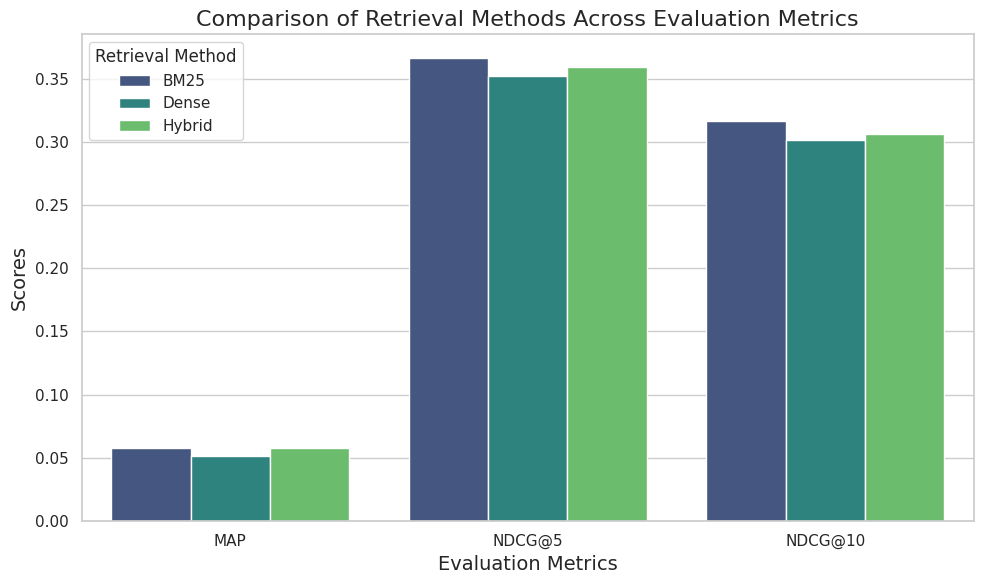

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    'Metric': ['MAP', 'NDCG@5', 'NDCG@10'],
    'BM25': [sparse_aggregate_metrics.get('map', 0.0),
             sparse_aggregate_metrics.get('ndcg_cut_5', 0.0),
             sparse_aggregate_metrics.get('ndcg_cut_10', 0.0)],
    'Dense': [dense_aggregate_metrics.get('map', 0.0),
              dense_aggregate_metrics.get('ndcg_cut_5', 0.0),
              dense_aggregate_metrics.get('ndcg_cut_10', 0.0)],
    'Hybrid': [hybrid_aggregate_metrics.get('map', 0.0),
               hybrid_aggregate_metrics.get('ndcg_cut_5', 0.0),
               hybrid_aggregate_metrics.get('ndcg_cut_10', 0.0)]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Metric', var_name='Retrieval Method', value_name='Score')

print(df_melted)

# Set the style for seaborn
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a barplot
sns.barplot(x='Metric', y='Score', hue='Retrieval Method', data=df_melted, palette='viridis')

# Add titles and labels
plt.title('Comparison of Retrieval Methods Across Evaluation Metrics', fontsize=16)
plt.xlabel('Evaluation Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)

# Adjust legend
plt.legend(title='Retrieval Method')

# Save the plot (optional)
plt.savefig('retrieval_methods_comparison.png', dpi=300)

# Display the plot
plt.tight_layout()
plt.show()